# Sensitivity analysis

In [1]:
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from h2ss import compare

In [110]:
cavern_diameter = np.arange(45, 106, step=5)
cavern_height = np.arange(80, 321, step=20)

In [114]:
def generate_sensitivity_data(cavern_diameter, cavern_height):
    """Generate data to perform sensitivity analysis"""
    os.makedirs(os.path.join("data", "sensitivity"), exist_ok=True)
    ds, extent, exclusions = compare.load_all_data()
    for d, h in product(cavern_diameter, cavern_height):
        filename = os.path.join("data", "sensitivity", f"sensitivity_d{d}_h{h}.csv")
        if not os.path.isfile(filename):
            df = compare.capacity_function(ds, extent, exclusions, d, h)
            df.to_csv(filename)
            print(f"{filename} done!")
        else:
            print(f"{filename} exists!")

In [119]:
# generate_sensitivity_data(cavern_diameter, cavern_height)

In [116]:
filelist = []
for d, h in product(cavern_diameter, cavern_height):
    filelist.append(os.path.join("data", "sensitivity", f"sensitivity_d{d}_h{h}.csv"))

In [120]:
df = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True,)

In [123]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [125]:
df["cavern_height"] = df["cavern_height"].astype(int)

In [126]:
df.describe()

,cavern_diameter,cavern_height,capacity
count,31780.00000,31780.000000,31780.000000
mean,64.28949,125.588420,71.731553
std,17.33300,51.088746,54.800259
min,45.00000,80.000000,10.663307
25%,50.00000,80.000000,34.958366
50%,60.00000,100.000000,55.633168
75%,75.00000,140.000000,89.563389
max,105.00000,320.000000,511.809957


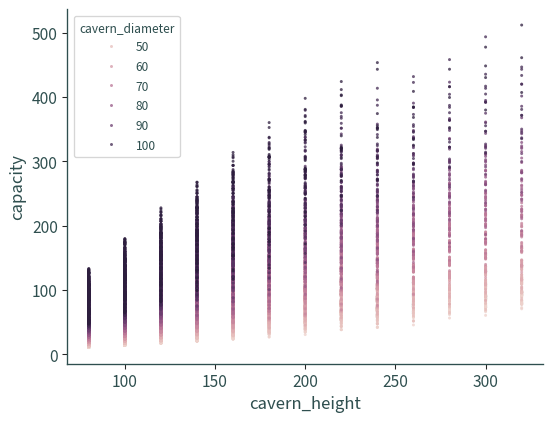

In [127]:
ax = sns.scatterplot(
    data=df,
    hue="cavern_diameter",
    y="capacity",
    x="cavern_height",
    linewidth=0,
    alpha=0.75,
    s=5,
)
sns.despine()
plt.show()

In [129]:
len(df["cavern_diameter"].unique()) == len(df["cavern_height"].unique())

True

## Mean capacity

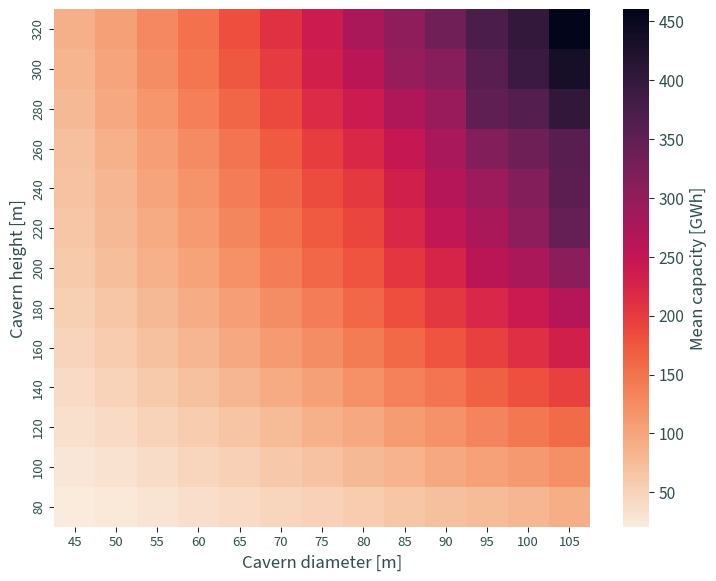

In [130]:
data = (
    df.groupby(["cavern_height", "cavern_diameter"])
    .mean()
    .reset_index()
    .pivot(index="cavern_height", columns="cavern_diameter", values="capacity")
    .sort_index(ascending=False)
)
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    data,
    ax=ax,
    cmap="rocket_r",
    cbar_kws={"label": "Mean capacity [GWh]"},
)
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Cavern height [m]")
ax.tick_params(axis="y", labelsize=11)
ax.tick_params(axis="x", labelsize=11)
plt.show()

## Total capacity

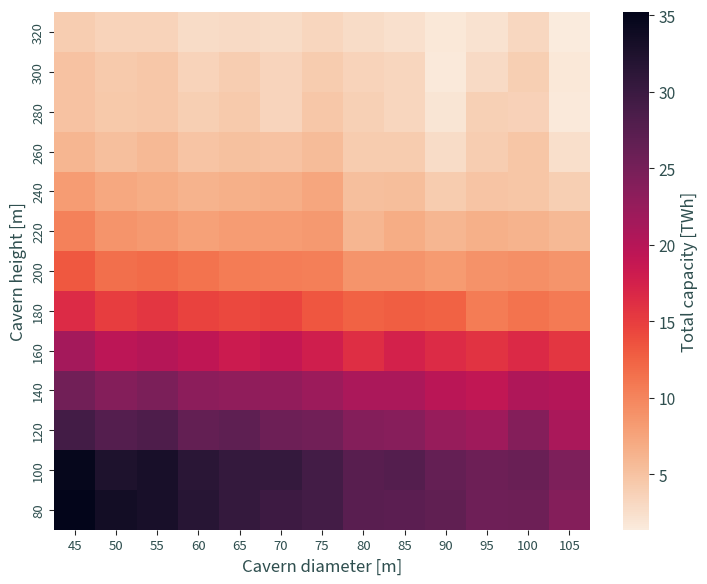

In [131]:
data = df.copy()
data["capacity"] = data["capacity"] / 1000
data = (
    data.groupby(["cavern_height", "cavern_diameter"])
    .sum()
    .reset_index()
    .pivot(index="cavern_height", columns="cavern_diameter", values="capacity")
    .sort_index(ascending=False)
)
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    data, ax=ax, cmap="rocket_r", cbar_kws={"label": "Total capacity [TWh]"}
)
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Cavern height [m]")
ax.tick_params(axis="y", labelsize=11)
ax.tick_params(axis="x", labelsize=11)
plt.show()

## Base case

In [132]:
base = df[
    (df["cavern_diameter"] == 85) & (df["cavern_height"] == 120)
].reset_index(drop=True)

In [133]:
base.describe()[["capacity"]]

,capacity
count,218.000000
mean,108.634041
std,25.946851
min,55.946359
25%,89.482842
50%,109.211632
75%,129.493525
max,158.798899


In [134]:
base_mean = base[["capacity"]].mean().values[0]

In [135]:
base_sum = base[["capacity"]].sum().values[0]

In [136]:
print(f"{base_sum:.3f}")

23682.221


## Base diameter, varying height

In [137]:
dd = df[(df["cavern_diameter"] == 85)].reset_index(drop=True)

In [138]:
dd_mean = (
    pd.DataFrame(dd.groupby("cavern_height").mean()["capacity"] - base_mean)
    / base_mean
    * 100
).reset_index()

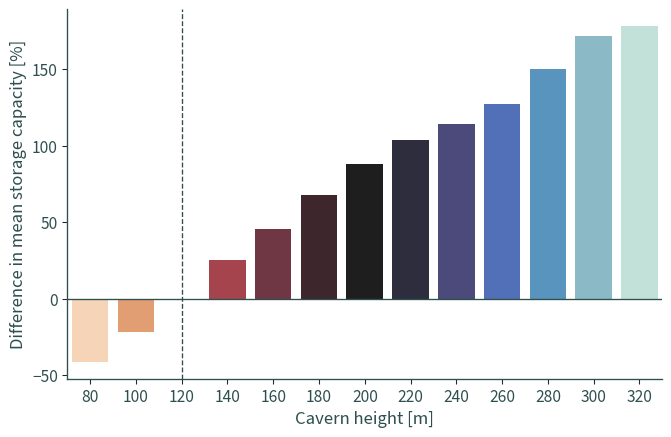

In [140]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=dd_mean,
    hue="cavern_height",
    y="capacity",
    x="cavern_height",
    palette="icefire_r",
    legend=False,
)
ax.axhline(0, color="darkslategrey", linewidth=1)
ax.axvline("120", color="darkslategrey", linewidth=1, linestyle="dashed")
ax.set_xlabel("Cavern height [m]")
ax.set_ylabel("Difference in mean storage capacity [%]")
sns.despine()
plt.show()

In [141]:
dd_sum = (
    pd.DataFrame(dd.groupby("cavern_height").sum()["capacity"] - base_sum)
    / base_sum
    * 100
).reset_index()

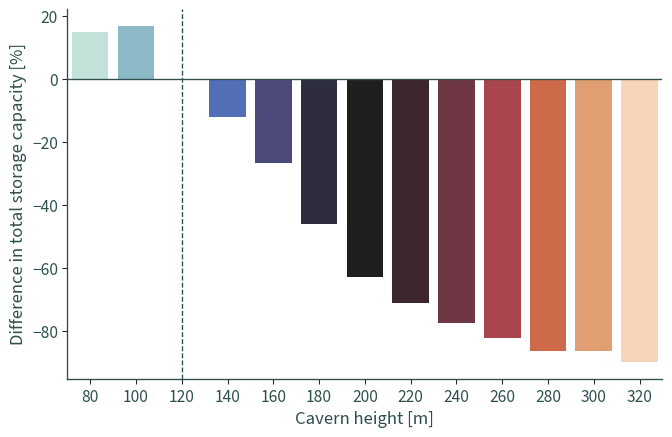

In [142]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=dd_sum,
    hue="cavern_height",
    y="capacity",
    x="cavern_height",
    palette="icefire",
    legend=False,
)
ax.axhline(0, color="darkslategrey", linewidth=1)
ax.axvline("120", color="darkslategrey", linewidth=1, linestyle="dashed")
ax.set_xlabel("Cavern height [m]")
ax.set_ylabel("Difference in total storage capacity [%]")
sns.despine()
plt.show()

## Base height, varying diameter

In [143]:
dh = df[(df["cavern_height"] == 120)].reset_index(drop=True)

In [144]:
dh_mean = (
    pd.DataFrame(dh.groupby("cavern_diameter").mean()["capacity"] - base_mean)
    / base_mean
    * 100
).reset_index()

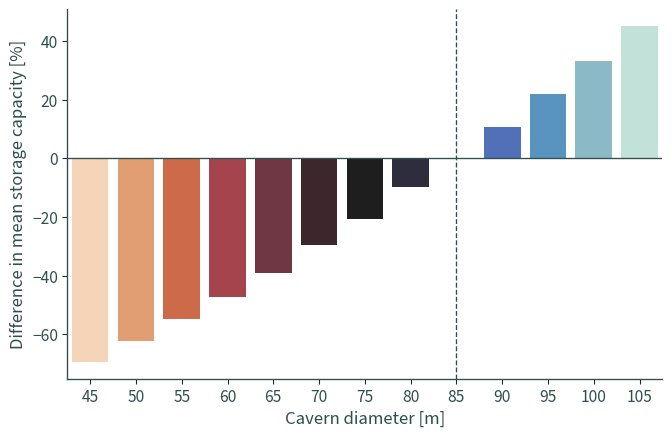

In [146]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=dh_mean,
    hue="cavern_diameter",
    y="capacity",
    x="cavern_diameter",
    palette="icefire_r",
    legend=False,
)
ax.axhline(0, color="darkslategrey", linewidth=1)
ax.axvline("85", color="darkslategrey", linewidth=1, linestyle="dashed")
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Difference in mean storage capacity [%]")
sns.despine()
plt.show()

In [147]:
dh_sum = (
    pd.DataFrame(dh.groupby("cavern_diameter").sum()["capacity"] - base_sum)
    / base_sum
    * 100
).reset_index()

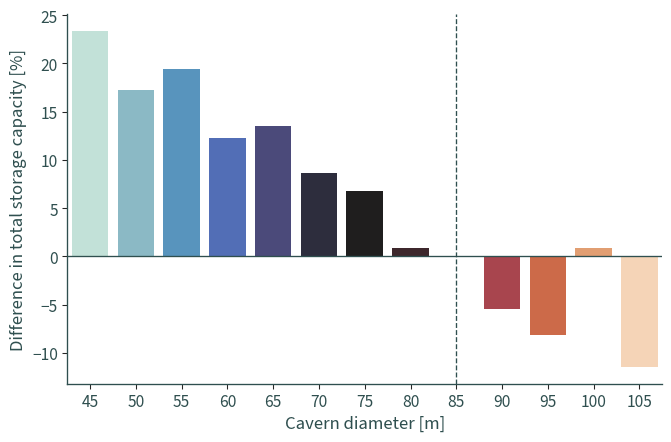

In [149]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=dh_sum,
    hue="cavern_diameter",
    y="capacity",
    x="cavern_diameter",
    palette="icefire",
    legend=False,
)
ax.axhline(0, color="darkslategrey", linewidth=1)
ax.axvline("85", color="darkslategrey", linewidth=1, linestyle="dashed")
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Difference in total storage capacity [%]")
sns.despine()
plt.show()

## Combined plots

In [150]:
dh_sum["type"] = "Total for the Kish Basin"
dh_mean["type"] = "Mean for a single cavern"
dd_sum["type"] = "Total for the Kish Basin"
dd_mean["type"] = "Mean for a single cavern"
dd_sum1["type"] = "Total for the Kish Basin"
dd_mean1["type"] = "Mean for a single cavern"

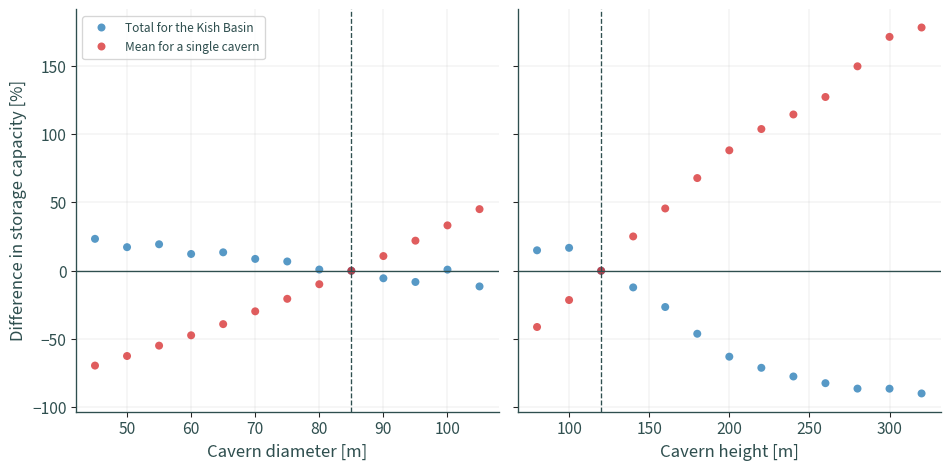

In [152]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.scatterplot(
    data=pd.concat([dh_sum, dh_mean]),
    y="capacity",
    x="cavern_diameter",
    hue="type",
    linewidth=0,
    alpha=0.75,
    palette=sns.color_palette(["tab:blue", "tab:red"]),
    ax=ax[0],
)
sns.scatterplot(
    data=pd.concat([dd_sum, dd_mean]),
    y="capacity",
    x="cavern_height",
    hue="type",
    linewidth=0,
    alpha=0.75,
    palette=sns.color_palette(["tab:blue", "tab:red"]),
    ax=ax[1],
    legend=False,
)
for a in ax.flat:
    a.axhline(0, color="darkslategrey", linewidth=1)
    a.xaxis.grid(True, linewidth=0.25)
    a.yaxis.grid(True, linewidth=0.25)
ax[0].axvline(85, color="darkslategrey", linewidth=1, linestyle="dashed")
ax[1].axvline(120, color="darkslategrey", linewidth=1, linestyle="dashed")
ax[0].set_xlabel("Cavern diameter [m]")
ax[1].set_xlabel("Cavern height [m]")
ax[0].set_ylabel("Difference in storage capacity [%]")
ax[0].legend(title=None)
sns.despine()
plt.tight_layout()
plt.show()

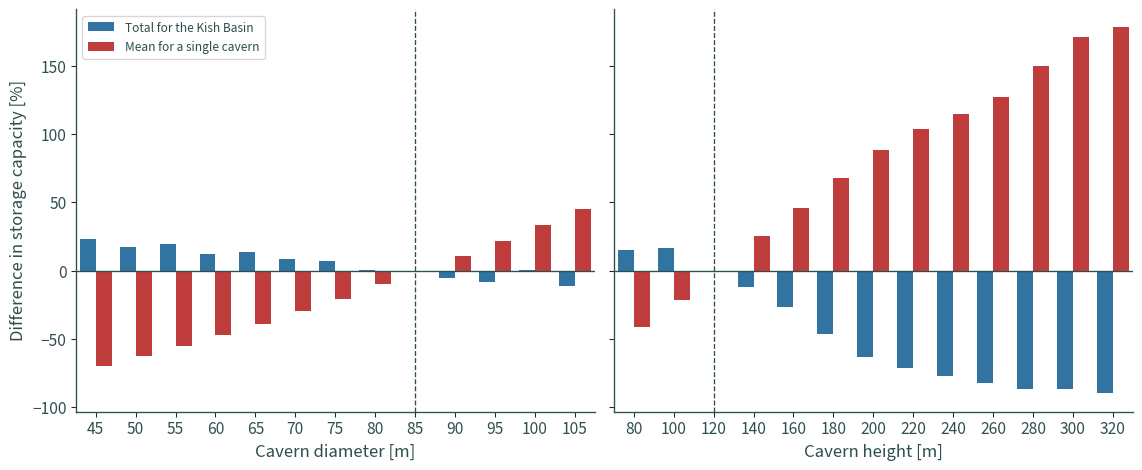

In [157]:
f, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.barplot(
    data=pd.concat([dh_sum, dh_mean]),
    hue="type",
    y="capacity",
    x="cavern_diameter",
    palette=sns.color_palette(["tab:blue", "tab:red"]),
    ax=ax[0],
)
sns.barplot(
    data=pd.concat([dd_sum, dd_mean]),
    hue="type",
    y="capacity",
    x="cavern_height",
    palette=sns.color_palette(["tab:blue", "tab:red"]),
    legend=False,
    ax=ax[1],
)

for a in ax.flat:
    a.axhline(0, color="darkslategrey", linewidth=1)
ax[0].axvline("85", color="darkslategrey", linewidth=1, linestyle="dashed")
ax[1].axvline("120", color="darkslategrey", linewidth=1, linestyle="dashed")
ax[0].set_xlabel("Cavern diameter [m]")
ax[1].set_xlabel("Cavern height [m]")
ax[0].set_ylabel("Difference in storage capacity [%]")
ax[0].legend(title=None)

sns.despine()
plt.tight_layout()
plt.savefig(
    os.path.join("graphics", "fig_sensitivity.jpg"),
    format="jpg",
    dpi=600,
)
plt.show()